<a href="https://colab.research.google.com/github/costpetrides/Fluid-Dynamics/blob/main/Simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import files
uploaded = files.upload()

Saving viz_tools.py to viz_tools.py



use_coriolis = True
use_beta = True
use_friction = False
use_wind = False
use_source = False
use_sink = False
g = 9.81
H = 100
dx = 6711.41 km
dy = 6711.41 km
dt = 21.43 s
f_0 = 0.0001
Max alpha = 0.00235707

Rossby radius: 313.2 km
Rossby number: 0.313209
Long Rossby wave speed: 1.962 m/s
Long Rossby transit time: 5.90 days

Time: 	0.12 hours
Step: 	20 / 5000
Mass: 	347.37679379183345

Time: 	0.24 hours
Step: 	40 / 5000
Mass: 	347.3767937918335

Time: 	0.36 hours
Step: 	60 / 5000
Mass: 	347.3767937918335

Time: 	0.48 hours
Step: 	80 / 5000
Mass: 	347.37679379183345

Time: 	0.60 hours
Step: 	100 / 5000
Mass: 	347.3767937918334

Time: 	0.71 hours
Step: 	120 / 5000
Mass: 	347.37679379183345

Time: 	0.83 hours
Step: 	140 / 5000
Mass: 	347.37679379183345

Time: 	0.95 hours
Step: 	160 / 5000
Mass: 	347.3767937918335

Time: 	1.07 hours
Step: 	180 / 5000
Mass: 	347.37679379183345

Time: 	1.19 hours
Step: 	200 / 5000
Mass: 	347.3767937918335

Time: 	1.31 hours
Step: 	220 / 5000
Mass: 	347.376

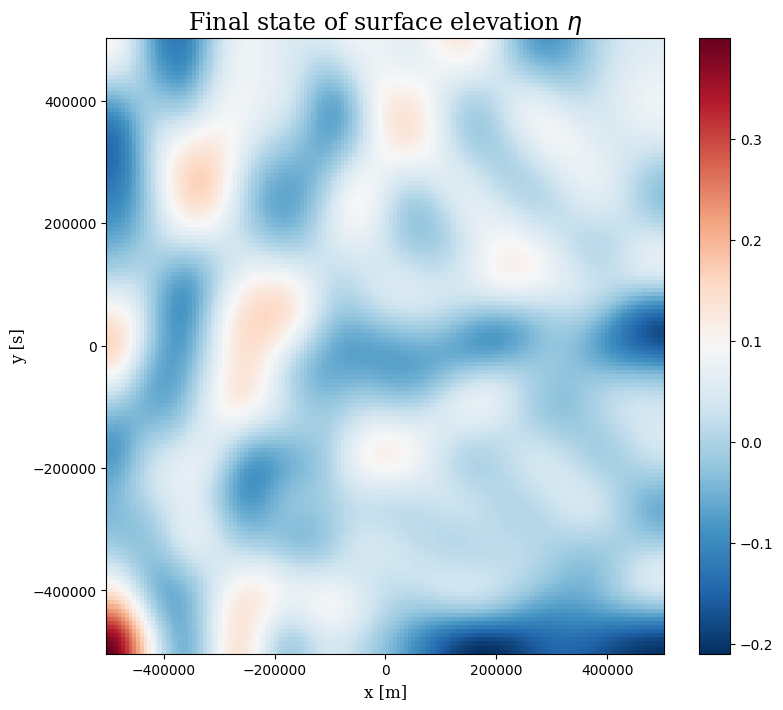

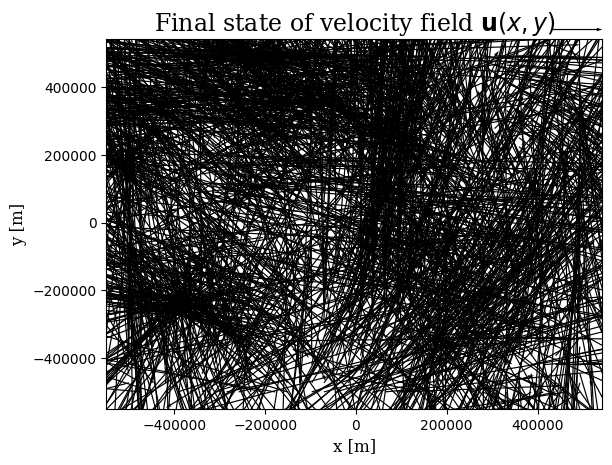

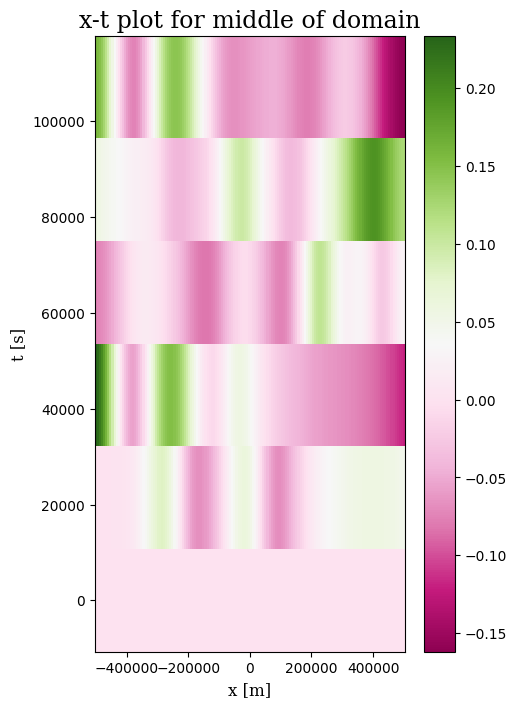

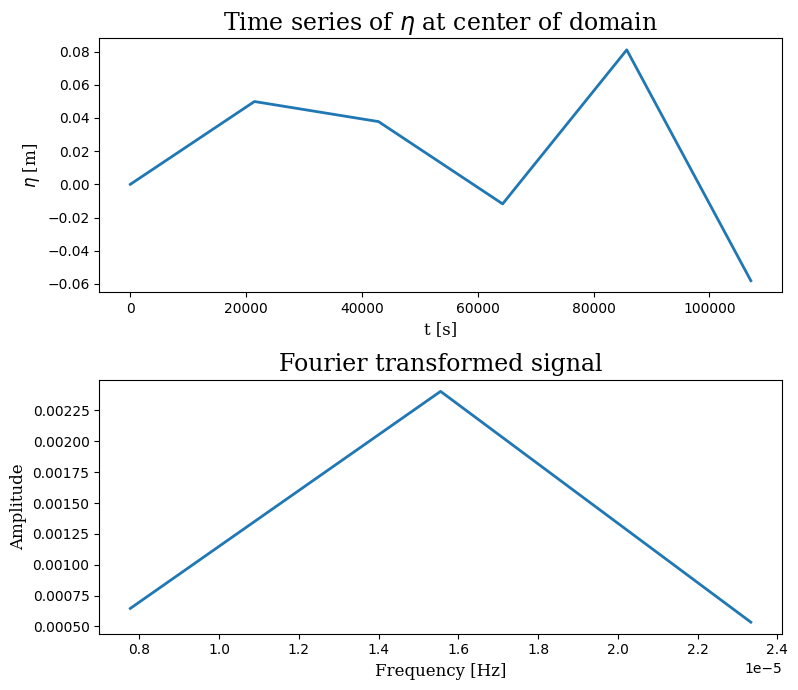

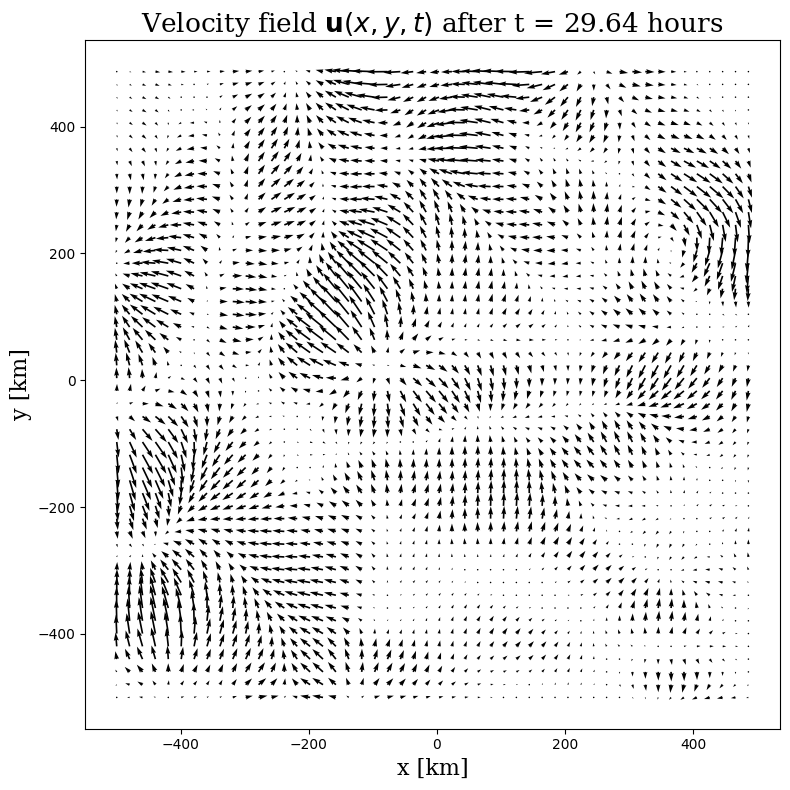

In [9]:

"""Script that solves that solves the 2D shallow water equations using finite
differences where the momentum equations are taken to be linear, but the
continuity equation is solved in its nonlinear form. The model supports turning
on/off various terms, but in its mst complete form, the model solves the following
set of eqations:

    du/dt - fv = -g*d(eta)/dx + tau_x/(rho_0*H)- kappa*u
    dv/dt + fu = -g*d(eta)/dy + tau_y/(rho_0*H)- kappa*v
    d(eta)/dt + d((eta + H)*u)/dx + d((eta + H)*u)/dy = sigma - w

where f = f_0 + beta*y can be the full latitude varying coriolis parameter.
For the momentum equations, an ordinary forward-in-time centered-in-space
scheme is used. However, the coriolis terms is not so trivial, and thus, one
first finds a predictor for u, v and then a corrected value is computed in
order to include the coriolis terms. In the continuity equation, it's used a
forward difference for the time derivative and an upwind scheme for the non-
linear terms. The model is stable under the CFL condition of

    dt <= min(dx, dy)/sqrt(g*H)    and    alpha << 1 (if coriolis is used)

where dx, dy is the grid spacing in the x- and y-direction respectively, g is
the acceleration of gravity and H is the resting depth of the fluid."""

import time
import numpy as np
import matplotlib.pyplot as plt
import viz_tools

# ==================================================================================
# ================================ Parameter stuff =================================
# ==================================================================================
# --------------- Physical prameters ---------------
L_x = 1E+6              # Length of domain in x-direction
L_y = 1E+6              # Length of domain in y-direction
g = 9.81                 # Acceleration of gravity [m/s^2]
H = 100                # Depth of fluid [m]
f_0 = 1E-4              # Fixed part ofcoriolis parameter [1/s]
beta = 2E-11            # gradient of coriolis parameter [1/ms]
rho_0 = 1024.0          # Density of fluid [kg/m^3)]
tau_0 = 0.1             # Amplitude of wind stress [kg/ms^2]
use_coriolis = True     # True if you want coriolis force
use_friction = False     # True if you want bottom friction
use_wind = False        # True if you want wind stress
use_beta = True         # True if you want variation in coriolis
use_source = False       # True if you want mass source into the domain
use_sink = False       # True if you want mass sink out of the domain
param_string = "\n================================================================"
param_string += "\nuse_coriolis = {}\nuse_beta = {}".format(use_coriolis, use_beta)
param_string += "\nuse_friction = {}\nuse_wind = {}".format(use_friction, use_wind)
param_string += "\nuse_source = {}\nuse_sink = {}".format(use_source, use_sink)
param_string += "\ng = {:g}\nH = {:g}".format(g, H)

# --------------- Computational prameters ---------------
N_x = 150                            # Number of grid points in x-direction
N_y = 150                            # Number of grid points in y-direction
dx = L_x/(N_x - 1)                   # Grid spacing in x-direction
dy = L_y/(N_y - 1)                   # Grid spacing in y-direction
dt = 0.1*min(dx, dy)/np.sqrt(g*H)    # Time step (defined from the CFL condition)
time_step = 1                        # For counting time loop steps
max_time_step = 5000                 # Total number of time steps in simulation
x = np.linspace(-L_x/2, L_x/2, N_x)  # Array with x-points
y = np.linspace(-L_y/2, L_y/2, N_y)  # Array with y-points
X, Y = np.meshgrid(x, y)             # Meshgrid for plotting
X = np.transpose(X)                  # To get plots right
Y = np.transpose(Y)                  # To get plots right
param_string += "\ndx = {:.2f} km\ndy = {:.2f} km\ndt = {:.2f} s".format(dx, dy, dt)

# Define friction array if friction is enabled.
if (use_friction is True):
    kappa_0 = 1/(5*24*3600)
    kappa = np.ones((N_x, N_y))*kappa_0
    #kappa[0, :] = kappa_0
    #kappa[-1, :] = kappa_0
    #kappa[:, 0] = kappa_0
    #kappa[:, -1] = kappa_0
    #kappa[:int(N_x/15), :] = 0
    #kappa[int(14*N_x/15)+1:, :] = 0
    #kappa[:, :int(N_y/15)] = 0
    #kappa[:, int(14*N_y/15)+1:] = 0
    #kappa[int(N_x/15):int(2*N_x/15), int(N_y/15):int(14*N_y/15)+1] = 0
    #kappa[int(N_x/15):int(14*N_x/15)+1, int(N_y/15):int(2*N_y/15)] = 0
    #kappa[int(13*N_x/15)+1:int(14*N_x/15)+1, int(N_y/15):int(14*N_y/15)+1] = 0
    #kappa[int(N_x/15):int(14*N_x/15)+1, int(13*N_y/15)+1:int(14*N_y/15)+1] = 0
    param_string += "\nkappa = {:g}\nkappa/beta = {:g} km".format(kappa_0, kappa_0/(beta*1000))

# Define wind stress arrays if wind is enabled.
if (use_wind is True):
    tau_x = -tau_0*np.cos(np.pi*y/L_y)*0
    tau_y = np.zeros((1, len(x)))
    param_string += "\ntau_0 = {:g}\nrho_0 = {:g} km".format(tau_0, rho_0)

# Define coriolis array if coriolis is enabled.
if (use_coriolis is True):
    if (use_beta is True):
        f = f_0 + beta*y        # Varying coriolis parameter
        L_R = np.sqrt(g*H)/f_0  # Rossby deformation radius
        c_R = beta*g*H/f_0**2   # Long Rossby wave speed
    else:
        f = f_0*np.ones(len(y))                 # Constant coriolis parameter

    alpha = dt*f                # Parameter needed for coriolis scheme
    beta_c = alpha**2/4         # Parameter needed for coriolis scheme

    param_string += "\nf_0 = {:g}".format(f_0)
    param_string += "\nMax alpha = {:g}\n".format(alpha.max())
    param_string += "\nRossby radius: {:.1f} km".format(L_R/1000)
    param_string += "\nRossby number: {:g}".format(np.sqrt(g*H)/(f_0*L_x))
    param_string += "\nLong Rossby wave speed: {:.3f} m/s".format(c_R)
    param_string += "\nLong Rossby transit time: {:.2f} days".format(L_x/(c_R*24*3600))
    param_string += "\n================================================================\n"

# Define source array if source is enabled.
if (use_source):
    sigma = np.zeros((N_x, N_y))
    sigma = 0.0001*np.exp(-((X-L_x/2)**2/(2*(1E+5)**2) + (Y-L_y/2)**2/(2*(1E+5)**2)))

# Define source array if source is enabled.
if (use_sink is True):
    w = np.ones((N_x, N_y))*sigma.sum()/(N_x*N_y)

# Write all parameters out to file.
with open("param_output.txt", "w") as output_file:
    output_file.write(param_string)

print(param_string)     # Also print parameters to screen
# ============================= Parameter stuff done ===============================

# ==================================================================================
# ==================== Allocating arrays and initial conditions ====================
# ==================================================================================
u_n = np.zeros((N_x, N_y))      # To hold u at current time step
u_np1 = np.zeros((N_x, N_y))    # To hold u at next time step
v_n = np.zeros((N_x, N_y))      # To hold v at current time step
v_np1 = np.zeros((N_x, N_y))    # To hold v at enxt time step
eta_n = np.zeros((N_x, N_y))    # To hold eta at current time step
eta_np1 = np.zeros((N_x, N_y))  # To hold eta at next time step

# Temporary variables (each time step) for upwind scheme in eta equation
h_e = np.zeros((N_x, N_y))
h_w = np.zeros((N_x, N_y))
h_n = np.zeros((N_x, N_y))
h_s = np.zeros((N_x, N_y))
uhwe = np.zeros((N_x, N_y))
vhns = np.zeros((N_x, N_y))

# Initial conditions for u and v.
u_n[:, :] = 0.0             # Initial condition for u
v_n[:, :] = 0.0             # Initial condition for u
u_n[-1, :] = 0.0            # Ensuring initial u satisfy BC
v_n[:, -1] = 0.0            # Ensuring initial v satisfy BC

# Initial condition for eta.
#eta_n[:, :] = np.sin(4*np.pi*X/L_y) + np.sin(4*np.pi*Y/L_y)
#eta_n = np.exp(-((X-0)**2/(2*(L_R)**2) + (Y-0)**2/(2*(L_R)**2)))
eta_n = np.exp(-((X-L_x/2.7)**2/(2*(0.05E+6)**2) + (Y-L_y/4)**2/(2*(0.05E+6)**2)))
#eta_n[int(3*N_x/8):int(5*N_x/8),int(3*N_y/8):int(5*N_y/8)] = 1.0
#eta_n[int(6*N_x/8):int(7*N_x/8),int(6*N_y/8):int(7*N_y/8)] = 1.0
#eta_n[int(3*N_x/8):int(5*N_x/8), int(13*N_y/14):] = 1.0
#eta_n[:, :] = 0.0

#viz_tools.surface_plot3D(X, Y, eta_n, (X.min(), X.max()), (Y.min(), Y.max()), (eta_n.min(), eta_n.max()))

# Sampling variables.
eta_list = list(); u_list = list(); v_list = list()         # Lists to contain eta and u,v for animation
hm_sample = list(); ts_sample = list(); t_sample = list()   # Lists for Hovmuller and time series
hm_sample.append(eta_n[:, int(N_y/2)])                      # Sample initial eta in middle of domain
ts_sample.append(eta_n[int(N_x/2), int(N_y/2)])             # Sample initial eta at center of domain
t_sample.append(0.0)                                        # Add initial time to t-samples
anim_interval = 20                                         # How often to sample for time series
sample_interval = 1000                                      # How often to sample for time series
# =============== Done with setting up arrays and initial conditions ===============

t_0 = time.perf_counter()  # For timing the computation loop

# ==================================================================================
# ========================= Main time loop for simulation ==========================
# ==================================================================================
while (time_step < max_time_step):
    # ------------ Computing values for u and v at next time step --------------
    u_np1[:-1, :] = u_n[:-1, :] - g*dt/dx*(eta_n[1:, :] - eta_n[:-1, :])
    v_np1[:, :-1] = v_n[:, :-1] - g*dt/dy*(eta_n[:, 1:] - eta_n[:, :-1])

    # Add friction if enabled.
    if (use_friction is True):
        u_np1[:-1, :] -= dt*kappa[:-1, :]*u_n[:-1, :]
        v_np1[:-1, :] -= dt*kappa[:-1, :]*v_n[:-1, :]

    # Add wind stress if enabled.
    if (use_wind is True):
        u_np1[:-1, :] += dt*tau_x[:]/(rho_0*H)
        v_np1[:-1, :] += dt*tau_y[:]/(rho_0*H)

    # Use a corrector method to add coriolis if it's enabled.
    if (use_coriolis is True):
        u_np1[:, :] = (u_np1[:, :] - beta_c*u_n[:, :] + alpha*v_n[:, :])/(1 + beta_c)
        v_np1[:, :] = (v_np1[:, :] - beta_c*v_n[:, :] - alpha*u_n[:, :])/(1 + beta_c)

    v_np1[:, -1] = 0.0      # Northern boundary condition
    u_np1[-1, :] = 0.0      # Eastern boundary condition
    # -------------------------- Done with u and v -----------------------------

    # --- Computing arrays needed for the upwind scheme in the eta equation.----
    h_e[:-1, :] = np.where(u_np1[:-1, :] > 0, eta_n[:-1, :] + H, eta_n[1:, :] + H)
    h_e[-1, :] = eta_n[-1, :] + H

    h_w[0, :] = eta_n[0, :] + H
    h_w[1:, :] = np.where(u_np1[:-1, :] > 0, eta_n[:-1, :] + H, eta_n[1:, :] + H)

    h_n[:, :-1] = np.where(v_np1[:, :-1] > 0, eta_n[:, :-1] + H, eta_n[:, 1:] + H)
    h_n[:, -1] = eta_n[:, -1] + H

    h_s[:, 0] = eta_n[:, 0] + H
    h_s[:, 1:] = np.where(v_np1[:, :-1] > 0, eta_n[:, :-1] + H, eta_n[:, 1:] + H)

    uhwe[0, :] = u_np1[0, :]*h_e[0, :]
    uhwe[1:, :] = u_np1[1:, :]*h_e[1:, :] - u_np1[:-1, :]*h_w[1:, :]

    vhns[:, 0] = v_np1[:, 0]*h_n[:, 0]
    vhns[:, 1:] = v_np1[:, 1:]*h_n[:, 1:] - v_np1[:, :-1]*h_s[:, 1:]
    # ------------------------- Upwind computations done -------------------------

    # ----------------- Computing eta values at next time step -------------------
    eta_np1[:, :] = eta_n[:, :] - dt*(uhwe[:, :]/dx + vhns[:, :]/dy)    # Without source/sink

    # Add source term if enabled.
    if (use_source is True):
        eta_np1[:, :] += dt*sigma

    # Add sink term if enabled.
    if (use_sink is True):
        eta_np1[:, :] -= dt*w
    # ----------------------------- Done with eta --------------------------------

    u_n = np.copy(u_np1)        # Update u for next iteration
    v_n = np.copy(v_np1)        # Update v for next iteration
    eta_n = np.copy(eta_np1)    # Update eta for next iteration

    time_step += 1

    # Samples for Hovmuller diagram and spectrum every sample_interval time step.
    if (time_step % sample_interval == 0):
        hm_sample.append(eta_n[:, int(N_y/2)])              # Sample middle of domain for Hovmuller
        ts_sample.append(eta_n[int(N_x/2), int(N_y/2)])     # Sample center point for spectrum
        t_sample.append(time_step*dt)                       # Keep track of sample times.

    # Store eta and (u, v) every anin_interval time step for animations.
    if (time_step % anim_interval == 0):
        print("Time: \t{:.2f} hours".format(time_step*dt/3600))
        print("Step: \t{} / {}".format(time_step, max_time_step))
        print("Mass: \t{}\n".format(np.sum(eta_n)))
        u_list.append(u_n)
        v_list.append(v_n)
        eta_list.append(eta_n)

# ============================= Main time loop done ================================
print("Main computation loop done!\nExecution time: {:.2f} s".format(time.perf_counter() - t_0))
print("\nVisualizing results...")

# ==================================================================================
# ================== Visualizing results by call to external file ==================
# ==================================================================================
viz_tools.pmesh_plot(X, Y, eta_n, "Final state of surface elevation $\eta$")
viz_tools.quiver_plot(X, Y, u_n, v_n, "Final state of velocity field $\mathbf{u}(x,y)$")
viz_tools.hovmuller_plot(x, t_sample, hm_sample)
viz_tools.plot_time_series_and_ft(t_sample, ts_sample)
#eta_anim = viz_tools.eta_animation(X, Y, eta_list, anim_interval*dt, "eta")
#eta_surf_anim = viz_tools.eta_animation3D(X, Y, eta_list, anim_interval*dt, "eta_surface")
quiv_anim = viz_tools.velocity_animation(X, Y, u_list, v_list, anim_interval*dt, "velocity")
# ============================ Done with visualization =============================

print("\nVisualization done!")
plt.show()